In [1]:
from IPython.display import clear_output
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
!pip install -qq implicit
import implicit
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
clear_output()
# https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from implicit.nearest_neighbours import bm25_weight  # remove superfans (superactive users here)

In [ ]:
# use case for implicit data - we do not have rating or someyhing like that, we use weighted behaviour from users

In [3]:
articles_df = pd.read_csv('/content/drive/My Drive/data/recommend/shared_articles.csv')
interactions_df = pd.read_csv('/content/drive/My Drive/data/recommend/users_interactions.csv')

In [4]:
articles_df.drop(['authorUserAgent', 'authorRegion', 'authorCountry'], axis=1, inplace=True)
interactions_df.drop(['userAgent', 'userRegion', 'userCountry'], axis=1, inplace=True)

In [5]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.drop('eventType', axis=1, inplace=True)

In [6]:
df = pd.merge(interactions_df[['contentId','personId', 'eventType']], articles_df[['contentId', 'title']], 
              how='inner', on='contentId')

In [7]:
df.head()

,contentId,personId,eventType,title
0,-3499919498720038879,-8845298781299428018,VIEW,Hiri wants to fix the workplace email problem
1,-3499919498720038879,-8845298781299428018,VIEW,Hiri wants to fix the workplace email problem
2,-3499919498720038879,-108842214936804958,VIEW,Hiri wants to fix the workplace email problem
3,-3499919498720038879,-1443636648652872475,VIEW,Hiri wants to fix the workplace email problem
4,-3499919498720038879,-1443636648652872475,VIEW,Hiri wants to fix the workplace email problem


In [8]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 3.0, 
   'FOLLOW': 4.0,
   'COMMENT CREATED': 5.0,  
}
df['eventStrength'] = df['eventType'].map(event_type_strength)

In [9]:
df.tail(1)

,contentId,personId,eventType,title,eventStrength
72268,-9040419159428373932,-7496361692498935601,VIEW,"Depois da Inteligência Artificial, vem aí a In...",1.0


In [10]:
df = df.drop_duplicates()
grouped_df = df.groupby(['personId', 'contentId', 'title']).sum().reset_index()
grouped_df.sample(5)

,personId,contentId,title,eventStrength
28344,3429602690322213789,-3040610224044779845,Things you probably didn't know you could do w...,1.0
29254,3609194402293569455,1561244083438776495,New Amazon Linux Container Image for Cloud and...,3.0
27995,3302556033962996625,1349971382589894814,The Most Intolerant Wins: The Dictatorship of ...,1.0
16157,-1443636648652872475,-7566966163569468290,Watch Google's AI master the infamously diffic...,1.0
14296,-2511855597392146401,4307023751244532288,MOBILE TIME - Nascem os primeiros chatbots bra...,1.0


In [12]:
grouped_df['title'] = grouped_df['title'].astype("category")
grouped_df['personId'] = grouped_df['personId'].astype("category")
grouped_df['contentId'] = grouped_df['contentId'].astype("category")
grouped_df['person_id'] = grouped_df['personId'].cat.codes
grouped_df['content_id'] = grouped_df['contentId'].cat.codes

sparse_content_person = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

In [35]:
sparse_content_person = bm25_weight(sparse_content_person, K1=100, B=0.8)
sparse_person_content = sparse_content_person.T.tocsr()

In [13]:
grouped_df.head()

,personId,contentId,title,eventStrength,person_id,content_id
0,-9223121837663643404,-8949113594875411859,"No Brasil, '25% dos celulares ainda são 'Burro...",1.0,0,65
1,-9223121837663643404,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,1.0,0,159
2,-9223121837663643404,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,1.0,0,187
3,-9223121837663643404,-8187220755213888616,Organizing for digital acceleration: Making a ...,1.0,0,195
4,-9223121837663643404,-7423191370472335463,"Espresso Intents: não é magia, é tecnologia! -...",1.0,0,313


In [36]:
model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50, use_gpu=False,
                                             random_state=1)
alpha = 15
data = (sparse_person_content * alpha).astype('double') # sparse_content_person!!!
model.fit(data)
# matrix factorization; like applying embedding (emb_size=20 here) in next section; 
# reducing dimensionalities of given sparse vector

  0%|          | 0/50 [00:00<?, ?it/s]

In [37]:
content_id = 450
n_similar = 10
# express each user as a vector of their taste values, 
# and at the same time express each item as a vector of what tastes they represent
person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms  # dot product or cosine
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

for content in similar:
    idx, score = content
    print(grouped_df.title.loc[grouped_df.content_id == idx].iloc[0])
# top 10 most similar titles

Google's fair use victory is good for open source
Google's Cloud Dataflow stomps on Apache Spark in new benchmark tests
Meet Mycroft, the open source AI who wants to rival Siri, Cortana, and Alexa | ZDNet
Machine learning is a poor fit for most businesses
Tensorflow wins
Deep learning software knows that a rose is a rose is a rosa rubiginosa
Evento em São Paulo traz grandes players do mercado mobile e desafio para startups - Startupi
Machine Learning Unconference
Google just open sourced something called 'Parsey McParseface,' and it could change AI forever
Up your DevOps chops with this online Kubernetes class


In [38]:
# def example from my other notebook with books
def recommend_similar(personid, top, rate=6, n_similar=10):
    interacted_content = grouped_df.loc[grouped_df['person_id'] == personid, 'eventStrength'].to_list()
    condition = ((grouped_df['person_id'] == personid) & (grouped_df['eventStrength'] >= rate))
    high_interaction_rate = grouped_df.loc[condition, 'title'].to_list()

    if len(high_interaction_rate) == 0:
        rate -= 1
        if rate < 0:
            print('No books found')
            return None
        return recommend_similar(personid, top, rate=rate)
    
    person_vecs = model.user_factors
    content_vecs = model.item_factors
    content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

    data = pd.DataFrame(columns=['Title', 'Rating'])

    for idx in high_interaction_rate:
        content_id = grouped_df.loc[grouped_df['title'] == idx, 'content_id'].unique()[0]
        scores = content_vecs.dot(content_vecs[content_id]) / content_norms
        
        top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
        similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

        for content in similar:
            idx, score = content
            loc_data = {}
            title = grouped_df['title'].loc[grouped_df.content_id == idx].iloc[0]
            rating = grouped_df['eventStrength'].loc[grouped_df.content_id == idx].mean()
            if grouped_df['content_id'].loc[grouped_df.content_id == idx].iloc[0] in interacted_content:
                continue
            loc_data['Title'] = title
            loc_data['Rating'] = rating
            data = data.append(loc_data, ignore_index=True)

    return data.sort_values(by='Rating', ascending=False).head(top)

In [39]:
recommend_similar(10, 10, rate=6, n_similar=3)

,Title,Rating
346,Feather: A Fast On-Disk Format for Data Frames...,8.600000
157,Deep learning software knows that a rose is a ...,4.666667
176,Deep learning software knows that a rose is a ...,4.666667
349,"The ""Joel Test"" for Data Science",4.400000
66,This startup uses machine learning and satelli...,4.000000
120,"Apple acquires Turi, a machine learning company",4.000000
173,"Apple acquires Turi, a machine learning company",4.000000
270,InsurTech: changing the world of risk - Chris ...,3.857143
272,"Rakuten Acquires Bitnet, Plans to Open Blockch...",3.600000
316,Debug Site Performance Using Web Profiler in D...,3.500000


In [40]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=10):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()  # [1, 2979], 2979 - items
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1  # [2979, ]
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()  # [1,30] x [30, 1895] = [1, 1895]

    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store titles and scores
    titles = []
    scores = []

    for idx in content_idx:
        # Append titles and scores to the list
        titles.append(grouped_df.title.loc[grouped_df.content_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'title': titles, 'score': scores})

    return recommendations

In [41]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for person with id 50
person_id = 50

#recommendations = recommend(person_id, sparse_person_content, content_vecs, person_vecs)
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)

print(recommendations)

                                               title     score
0  Custo do Erro - Cinco motivos para investir em...  1.000000
1  15 Interesting JavaScript and CSS Libraries fo...  0.929177
2  'The Simpsons' celebrates 600 episodes with a ...  0.919763
3  Node.js Examples - How Enterprises use Node in...  0.902692
4  Ray Kurzweil: The world isn't getting worse - ...  0.848675
5  Drupal How-To: Responsive or Adaptive Images? ...  0.845622
6           Drupal and ambitious digital experiences  0.841543
7  How to use Docker to run ASP.NET Core apps on ...  0.832912
8                                         Paragraphs  0.815972
9  Debugging WordPress: 11 Powerful Tips and Tech...  0.808480


In [42]:
# https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
# Create recommendations for user with id 2025
user_id = 50

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_person_content[user_id,:])

titles = []
scores = []

# Get artist names from ids
for idx, score in zip(*recommended):
    #idx, score = item
    titles.append(grouped_df.title.loc[grouped_df.content_id == idx].iloc[0])
    scores.append(score)

# Create a dataframe of artist names and scores
recommendations = pd.DataFrame({'title': titles, 'score': scores})

print(recommendations)

                                               title     score
0  Custo do Erro - Cinco motivos para investir em...  1.424802
1  15 Interesting JavaScript and CSS Libraries fo...  1.273963
2  'The Simpsons' celebrates 600 episodes with a ...  1.253913
3  Node.js Examples - How Enterprises use Node in...  1.217553
4  Ray Kurzweil: The world isn't getting worse - ...  1.102507
5  Drupal How-To: Responsive or Adaptive Images? ...  1.096006
6           Drupal and ambitious digital experiences  1.087319
7  How to use Docker to run ASP.NET Core apps on ...  1.068935
8                                         Paragraphs  1.032856
9  Debugging WordPress: 11 Powerful Tips and Tech...  1.016900


In [54]:
set(grouped_df[grouped_df.person_id == user_id]['title'].values).intersection(set(recommendations.title.values))

set()

$$precision = \frac{|\{relevant\_items\}\cap\{retrieved\_items\}|}{|\{retrieved\_items\}|}$$

$$recall = \frac{|\{relevant\_items\}\cap\{retrieved\_items\}|}{|\{relevant\_items\}|}$$

$$AP = \sum_{k=1}^{n}p(k)rel(k)$$ where p(k) is precision@k, n is the number of items in recommendation list, rel(k) is an indicator function that equals 1 if the rank k item is relevant and 0 otherwise

$$MAP = \frac{1}{U_{all}}\sum_{u=1}^{|All|}AP(u)$$

In [ ]:
import ml_metrics
score = ml_metrics.mapk(actual, predicted, 5)

1895

In [ ]:
recommended[1]

array([0.57770497, 0.550107  , 0.53452843, 0.45759815, 0.43310368,
       0.41550496, 0.40621683, 0.40207216, 0.3903405 , 0.32356757],
      dtype=float32)

In [ ]:
# Content-based recommendations

In [ ]:
!pip install rake_nltk

In [ ]:
import pandas as pd
from rake_nltk import Rake  # automaticly removes symbols and stop-words
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

In [ ]:
df = df[['Title','Genre','Director','Actors','Plot']]
df.head(2)

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,"Crime, Drama",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
# initializing the new column
df['Key_words'] = ""

for index, row in df.iterrows():
    plot = row['Plot']
    
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column for the corresponding movie
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
df.drop(columns = ['Plot'], inplace = True)

In [ ]:
for index, row in df.iterrows():
    row['Genre'] = row['Genre'].replace(',', '').lower()
    row['Key_words'] = ' '.join(row['Key_words'])
    row['Director'] = ' '.join([dir.replace(' ', '').lower() for dir in row['Director'].split(',')])
    row['Actors'] = ' '.join([act.replace(' ', '').lower() for act in row['Actors'].split(',')])
df.head()

,Title,Genre,Director,Actors,Key_words
0,The Shawshank Redemption,crime drama,frankdarabont,timrobbins morganfreeman bobgunton williamsadler,two imprisoned men bond number years finding s...
1,The Godfather,crime drama,francisfordcoppola,marlonbrando alpacino jamescaan richards.caste...,aging patriarch organized crime dynasty transf...
2,The Godfather: Part II,crime drama,francisfordcoppola,alpacino robertduvall dianekeaton robertdeniro,early life career vito corleone 1920s new york...
3,The Dark Knight,action crime drama,christophernolan,christianbale heathledger aaroneckhart michael...,menace known joker emerges mysterious past wre...
4,12 Angry Men,crime drama,sidneylumet,martinbalsam johnfiedler leej.cobb e.g.marshall,jury holdout attempts prevent miscarriage just...


In [ ]:
df['bag_of_words'] = ''
for index, row in df.iterrows():
    row['bag_of_words'] = row['Genre'] + ' ' + row['Director'] + ' ' + row['Actors'] + ' ' + row['Key_words']

In [ ]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# maybe use tfidvectorizer or hashingvectorizer

In [ ]:
df.set_index(df.Title, drop=True, inplace=True)

In [ ]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(df.index)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [ ]:
recommendations('Fargo')

['No Country for Old Men',
 'The Departed',
 'Rope',
 'The Big Lebowski',
 'Reservoir Dogs',
 'The Godfather',
 'The Godfather: Part II',
 'On the Waterfront',
 'Goodfellas',
 'Arsenic and Old Lace']

In [ ]:
# we can use the results in first block: similar movies + movies liked by similar users
# use deep learning, including autoencoders, embedding models, transformers

# in keras NN we use explicit data, where we predict the missing value of rating for movie the user have not seen
# based on other users opinion (recomendation vector taken from dot product), 
# taking embeddings to reduce the dimesionality (factorize) and get user_vec and 
# movie_vec similarity goes from dot product of user_vec and movie_vec, feed it to sigmoid to get the normalized
# predicted rating value
# ALS also must work here

In [ ]:
# path /content/drive/My Drive/data/recommender/ratings.csv ./data/recommender/movies.csv

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
movies = pd.read_csv('/content/drive/My Drive/data/recommender/movies.csv')
user_ratings = pd.read_csv('/content/drive/My Drive/data/recommender/ratings.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
user_ratings.head()

,userId,movieId,rating,user,movie
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4


In [ ]:
movies['title'] = movies['title'].str.strip().str[:-7]
movies['genres'] = movies['genres'].str.replace('|', ' ')
user_ratings = user_ratings.drop(columns=['timestamp'])

In [ ]:
top_N = 25
txt = movies.title.str.lower().str.cat(sep=' ')

In [ ]:
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + [')', '(', ',', ':', "'s", '.', '!', '&', '?']
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords)

All frequencies:
       Frequency
Word            
2            180
man          179
love         109
la           107
ii           105
a.k.a         99
movie         94
night         86
story         80
life          76


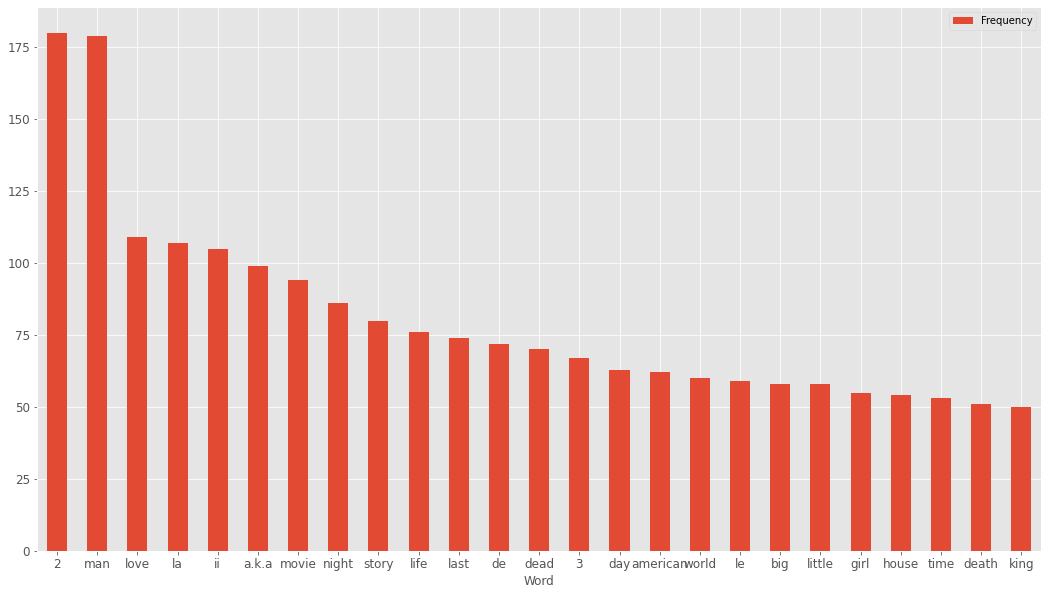

In [ ]:
print('All frequencies:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word').head(10)
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(18, 10), fontsize=12)

All frequencies:
             Frequency
Word                  
drama             4361
comedy            3756
thriller          1894
action            1828
romance           1596
adventure         1263
crime             1199
sci-fi             980
horror             978
fantasy            779
children           664
animation          611
mystery            573
documentary        440
war                382
musical            334
western            167
imax               158
film-noir           87
genres              34
listed              34


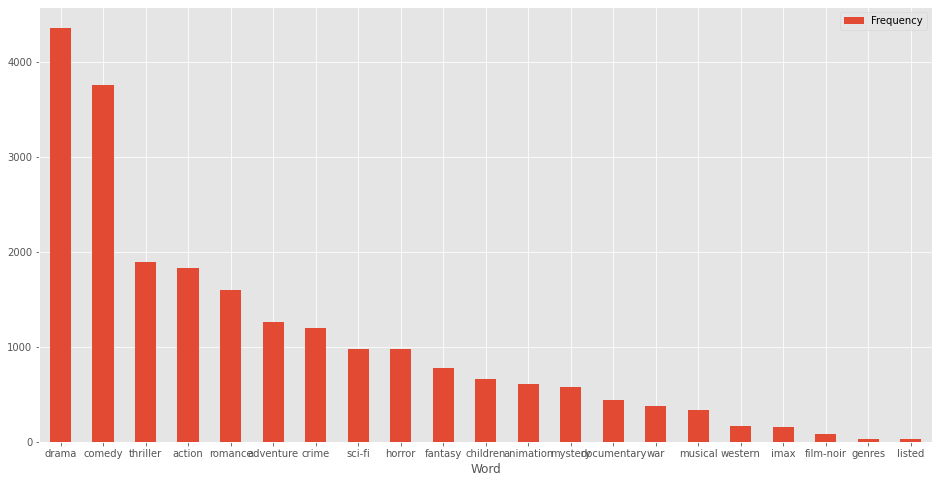

In [ ]:
top_N = 25

txt = movies.genres.str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + [')', '(', ',', ':', "'s", '.', '!', '&', '?']
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word').head(25)
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(16, 8), fontsize=10)

In [ ]:
movies.sample(2)

,movieId,title,genres
8529,114795,Dracula Untold,Action Drama Fantasy
9470,168418,The Boss Baby,Animation Children Comedy


In [ ]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(movies['genres'].values)
feature_names = vectorizer.get_feature_names()
genres_bow = pd.DataFrame(x.toarray(), columns=feature_names)
genres_bow['combined']= genres_bow.values.tolist()

In [ ]:
movies['genres'] = genres_bow['combined']
movies.head()

,movieId,title,genres
0,1,Toy Story,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Content-Based

In [ ]:
# The function below returns IDs for top N movies similar to the given one.
def get_cossim(movieid, top):
    # Creating dataframe with only IDs and genres
    movies_to_search = movies[['movieId', 'genres']]
    # Remove the ID of the movie we are measuring distance to
    movies_to_search = movies_to_search[movies_to_search.movieId != movieid]
    # Saving distances to new column
    movies_to_search['dist'] = movies_to_search['genres'].apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(movies.loc[movies['movieId'] == movieid]['genres'].values[0]).reshape(1, -1)))
    # Remove the genres column
    movies_to_search = movies_to_search.drop(columns=['genres'])
    # Distance value is in the list inside of the list so we need to unpack it
    movies_to_search = movies_to_search.explode('dist').explode('dist')
    # Sort the data and return top values
    return movies_to_search.sort_values(by=['dist'], ascending=False)['movieId'].head(top).values

In [ ]:
# The next function takes 20 top-rated movies by a selected user and returns 5 similar movies for each of those.
def get_similar(userid):
    # Take all the movies watched by user
    movies_watched_by_user = user_ratings[user_ratings.userId == user_id]
    # Only 4.5 or higher rating filtered
    movies_watched_by_user = movies_watched_by_user[movies_watched_by_user['rating'] > 4.5]
    # Taking top 20 with highest ratings
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(20))
    top_movies_user['watched_movieId'] = top_movies_user['movieId']
    top_movies_user = top_movies_user[['userId', 'watched_movieId']]
    # Find 5 similar movies for each of the selected above
    top_movies_user['similar'] = top_movies_user['watched_movieId'].apply(lambda x: (get_cossim(x, 5)))
    # Remove movies that user have already watched from recommendations
    result = [x for x in np.concatenate(top_movies_user['similar'].values, axis=0).tolist() if x not in top_movies_user.watched_movieId.values.tolist()]
    return result

In [ ]:
# 'get_top' function returns top N recommended movies sorted by mean user rating. 
# (only movies with 10 or more ratings are used).
def get_top(id, top):
    # taking movies that user may like
    smlr = get_similar(id)    
    # Calculating mean rating for every movie
    movie_data = pd.merge(user_ratings, movies, on='movieId')
    ratings_mean_count = pd.DataFrame(movie_data.groupby('movieId')['rating'].mean())
    ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('movieId')['rating'].count())
    # Sorting movies with 10 or more ratings by users
    ratings_mean_count = ratings_mean_count[ratings_mean_count['rating_counts'] > 10]
    # Returning top N movies sorted by rating
    return ratings_mean_count[ratings_mean_count.index.isin(smlr)].sort_values(by=['rating'], ascending=False).head(top)

In [ ]:
# Collaborative-based

In [ ]:
df = user_ratings

In [ ]:
user_ids = df["userId"].unique().tolist()
# Reassign user IDs
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
# Reassign movie IDs
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df.tail()

,userId,movieId,rating,user,movie
100831,610,166534,4.0,609,3120
100832,610,168248,5.0,609,2035
100833,610,168250,5.0,609,3121
100834,610,168252,5.0,609,1392
100835,610,170875,3.0,609,2873


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(  # like PCA, input=num_distinct_words, output_size
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0005)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6495 - val_loss: 0.6276
Epoch 2/15
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6205 - val_loss: 0.6266
Epoch 3/15
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6129 - val_loss: 0.6185
Epoch 4/15
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6085 - val_loss: 0.6165
Epoch 5/15
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6053 - val_loss: 0.6125
Epoch 6/15
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6032 - val_loss: 0.6111
Epoch 7/15
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6013 - val_loss: 0.6095
Epoch 8/15
1418/1418 [==============================] - 8s 6ms/step - loss: 0.5998 - val_loss: 0.6087
Epoch 9/15
1418/1418 [==============================] - 8s 6ms/step - loss: 0.5986 - val_loss: 0.6077
Epoch 10/15
1418/1418 [==============================] - 9s 6ms/step - loss: 0.59

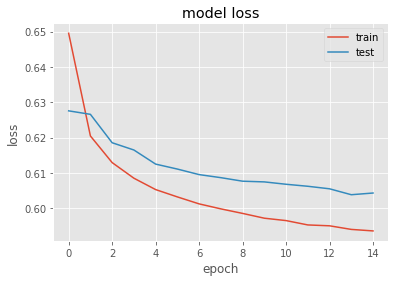

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="best")
plt.show()

In [ ]:
user_id = 10

In [ ]:
top = get_top(user_id, 20)
content_rec = top.index.values.tolist()

In [ ]:
movie_df = pd.read_csv('/content/drive/My Drive/data/recommender/movies.csv') 

# Searching for movies that user already watched
movies_watched_by_user = df[df.userId == user_id]
# Searching for movies that user haven't watched yet
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

In [ ]:
# Predicting ratings for movies
ratings = model.predict(user_movie_array).flatten()
# Sorting predicted ratings and taking top 20
top_ratings_indices = ratings.argsort()[-20:][::-1]
# Getting the actual IDs for movies
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

In [ ]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print("Movies with high ratings from user")
print("----" * 10)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(10)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 10
Movies with high ratings from user
----------------------------------------
Troy (2004) : Action|Adventure|Drama|War
First Daughter (2004) : Comedy|Romance
Education, An (2009) : Drama|Romance
Despicable Me (2010) : Animation|Children|Comedy|Crime
King's Speech, The (2010) : Drama
Dark Knight Rises, The (2012) : Action|Adventure|Crime|IMAX
Intouchables (2011) : Comedy|Drama
Skyfall (2012) : Action|Adventure|Thriller|IMAX
Spectre (2015) : Action|Adventure|Crime
The Intern (2015) : Comedy


In [ ]:
print("----" * 10)
print("Top 10 movie recommendations")
print("----" * 10)
# randomly pick 10 movies from recommendations
to_recommend = random.sample((content_rec + recommended_movie_ids), 10) # content-based, collaborative-based
recommended_movies = movie_df[movie_df["movieId"].isin(to_recommend)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

----------------------------------------
Top 10 movie recommendations
----------------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
While You Were Sleeping (1995) : Comedy|Romance
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Apocalypse Now (1979) : Action|Drama|War
Great Escape, The (1963) : Action|Adventure|Drama|War
Licence to Kill (1989) : Action|Adventure|Thriller
Thunderball (1965) : Action|Adventure|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Up in the Air (2009) : Drama|Romance


In [ ]:
# as an exersice try to apply als to the movielens

In [ ]:
ratings = pd.read_csv('/content/drive/My Drive/data/recommender/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/data/recommender/movies.csv')

In [ ]:
ratings.drop('timestamp', axis=1, inplace=True)

In [ ]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
sparse_content_person = sparse.csr_matrix((ratings['rating'].astype(float), (ratings['movieId'], ratings['userId'])))
sparse_person_content = sparse.csr_matrix((ratings['rating'].astype(float), (ratings['userId'], ratings['movieId'])))

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=70, use_gpu=False,
                                             random_state=1)
alpha = 40
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

  0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=10):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store titles and scores
    titles = []
    scores = []

    for idx in content_idx:
        # Append titles and scores to the list
        titles.append(movies.title.loc[ratings.movieId == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'title': titles, 'score': scores})

    return recommendations

In [ ]:
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

In [ ]:
recommdations = recommend(10, sparse_person_content, person_vecs, content_vecs, 15)

In [ ]:
recommdations

,title,score
0,"Curse of the Jade Scorpion, The (2001)",1.000000
1,"Thing from Another World, The (1951)",0.970552
2,"Lavender Hill Mob, The (1951)",0.970007
3,"Color Purple, The (1985)",0.952210
4,"Day the Earth Stood Still, The (1951)",0.932182
5,We're No Angels (1955),0.906593
6,Timecop (1994),0.903198
7,"Negotiator, The (1998)",0.886059
8,Escape from the Planet of the Apes (1971),0.868285
9,"Quiet Man, The (1952)",0.860474


In [ ]:
!pip install pyspark

In [ ]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local') #https://stackoverflow.com/questions/30763951/spark-context-sc-not-defined
spark = SparkSession(sc)

In [ ]:
data_schema = StructType([
    StructField('userId',IntegerType(), False),
    StructField('movieId',IntegerType(), False),
    StructField('rating',FloatType(), False),
    StructField('timestamp',IntegerType(),False)
])
final_stat = spark.read.csv(
    '/content/drive/My Drive/data/recommender/ratings.csv', header=True, schema=data_schema
).cache()

In [ ]:
ratings = (final_stat
    .select(
        'userId',
        'movieId',
        'rating',
    )
).cache()

In [ ]:
train, test = ratings.randomSplit([0.8, 0.2])

In [ ]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=50, #10 was by default
          maxIter=5, regParam=0.1,
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          implicitPrefs=False)
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.876571610932103


In [ ]:
%%time
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.count()
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
movieRecs.count()

CPU times: user 115 ms, sys: 2.61 ms, total: 118 ms
Wall time: 15.7 s


In [ ]:
userRecs_df = userRecs.toPandas()
print(userRecs_df.shape)

movieRecs_df = movieRecs.toPandas()
print(movieRecs_df.shape)

(610, 2)
(9052, 2)


In [ ]:
userRecs_df.head()

,userId,recommendations
0,1,"[(5915, 5.377357006072998), (5490, 5.327973842..."
1,2,"[(131724, 4.880086898803711), (80906, 4.604270..."
2,3,"[(70946, 4.940567493438721), (6835, 4.90392589..."
3,4,"[(3851, 4.938390731811523), (1733, 4.905546188..."
4,5,"[(475, 4.622707843780518), (527, 4.35841178894..."


In [ ]:
userRecs_df[userRecs_df.userId == 10].iloc[:, 1].values.flatten()[0][0]

Row(movieId=71579, rating=4.716228485107422)

In [ ]:
rec_for_user10 = pd.DataFrame(columns=['title', 'rating'])
for item in userRecs_df[userRecs_df.userId == 10].iloc[:, 1].values.flatten()[0]:
    rec_for_user10 = rec_for_user10.append({'title': item['movieId'], 'rating': item['rating']}, ignore_index=True)

In [ ]:
mapped_title = {k: v for k, v in zip(movies.movieId, movies.title)}

In [ ]:
rec_for_user10 = rec_for_user10.title.map(mapped_title)

In [ ]:
rec_for_user10

0               Education, An (2009)
1              First Daughter (2004)
2                  The Intern (2015)
3    The Hundred-Foot Journey (2014)
4    Priceless (Hors de prix) (2006)
5             Chasing Liberty (2004)
6                Holiday, The (2006)
7                Intouchables (2011)
8               Proposal, The (2009)
9               Notebook, The (2004)
Name: title, dtype: object

In [ ]:
ratings.toPandas().loc[((ratings.toPandas().rating > 4.5) & (ratings.toPandas().userId == 10)), 'movieId'].map(mapped_title)

1161                      Troy (2004)
1163             Notebook, The (2004)
1167            First Daughter (2004)
1176             Batman Begins (2005)
1181             Casino Royale (2006)
1182              Holiday, The (2006)
1205             Education, An (2009)
1216             Despicable Me (2010)
1219        King's Speech, The (2010)
1229    Dark Knight Rises, The (2012)
1230              Intouchables (2011)
1236                   Skyfall (2012)
1256                   Spectre (2015)
1258                The Intern (2015)
Name: movieId, dtype: object

In [ ]:
# remove duplicates by custom function

Row(userId=1, movieId=1, rating=4.0)

In [ ]:
# usage of clustering to find out similar groups of people and content they watch by rating

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

In [ ]:
ratings = pd.read_csv('/content/drive/My Drive/data/recommender/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/data/recommender/movies.csv')

In [ ]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [ ]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


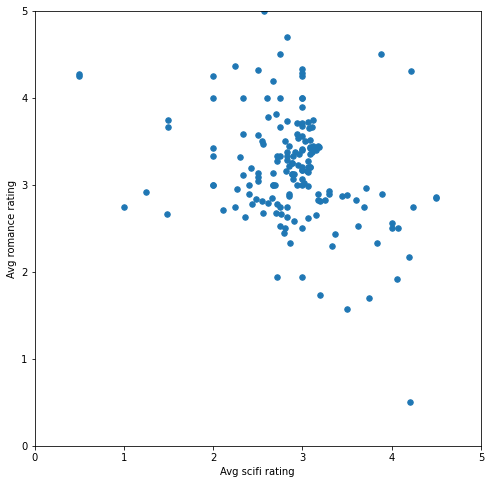

In [ ]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

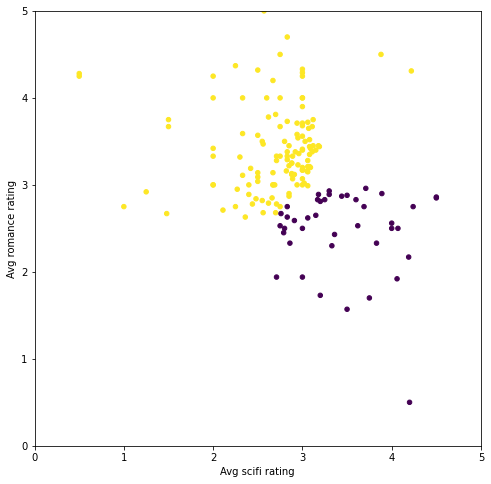

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
# Plot
draw_clusters(biased_dataset, predictions)

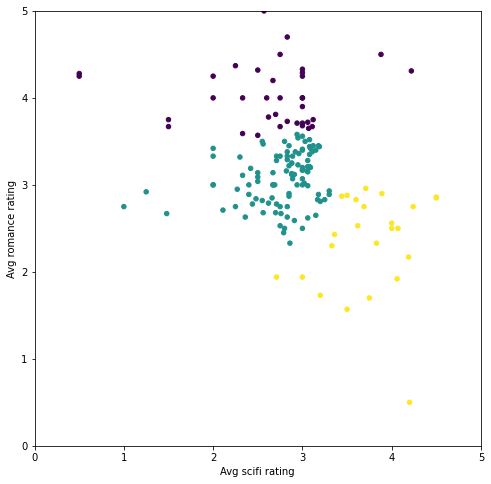

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

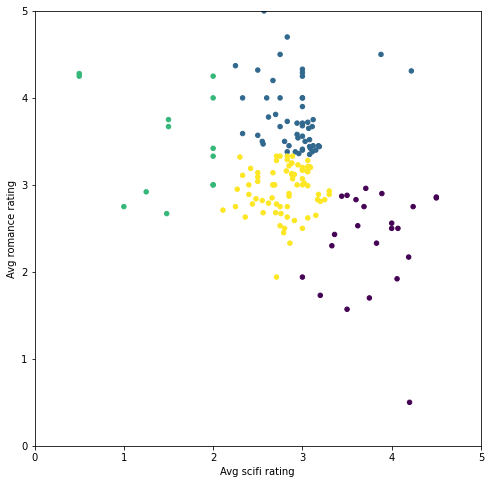

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)
# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  


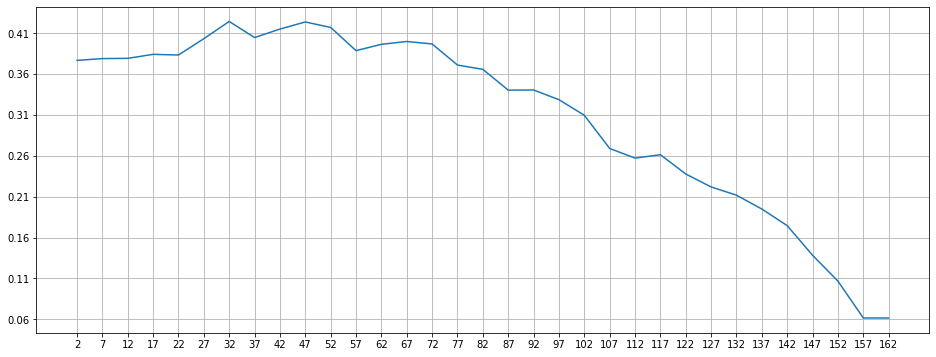

In [ ]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')
# originally k=7 but from the graph below it may be better 32

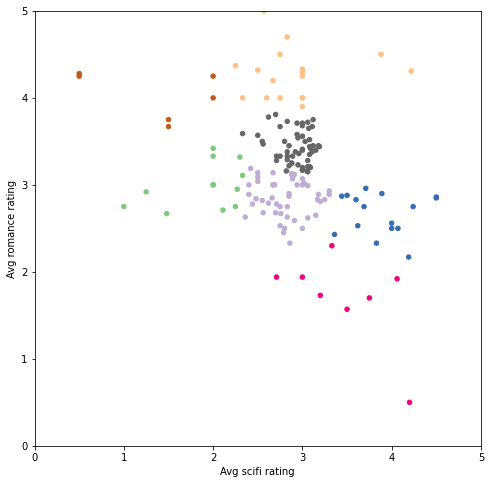

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [ ]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],                                          
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


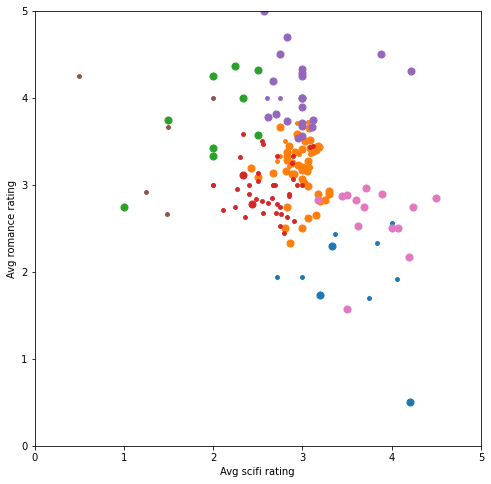

In [ ]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating', 'avg_action_rating']].values
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)
# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies
def get_users_who_rate_the_most(most_rated_movies, n_users):
    users = {}
    for j, (i, row) in enumerate(most_rated_movies.iterrows(),1):
        users.update({j: len(row) - row.isnull().sum()})
    #users = {k: v for k,v in sorted(users.items(), key=lambda x: -x[1])}
    most_rated_movies = pd.concat([pd.Series(list(users.values())), most_rated_movies], axis=1)
    most_rated_movies = most_rated_movies.rename(columns={0: 'count'})
    most_rated_movies = most_rated_movies.sort_values(by='count', ascending=False)
    most_rated_movies.drop('count', axis=1, inplace=True)
    return most_rated_movies.head(n_users)
# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,3.5,4.0,5.0,4.5,3.0,3.0,4.0,4.5,5.0,4.5,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,4.0,4.0,5.0,4.0,3.5,4.0,4.0,4.5,4.0,5.0,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,4.5,3.0,5.0,3.5,4.0,4.5,3.0,3.5,5.0,3.5,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,2.5,2.5,5.0,3.0,5.0,4.0,4.0,3.0,5.0,4.5,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


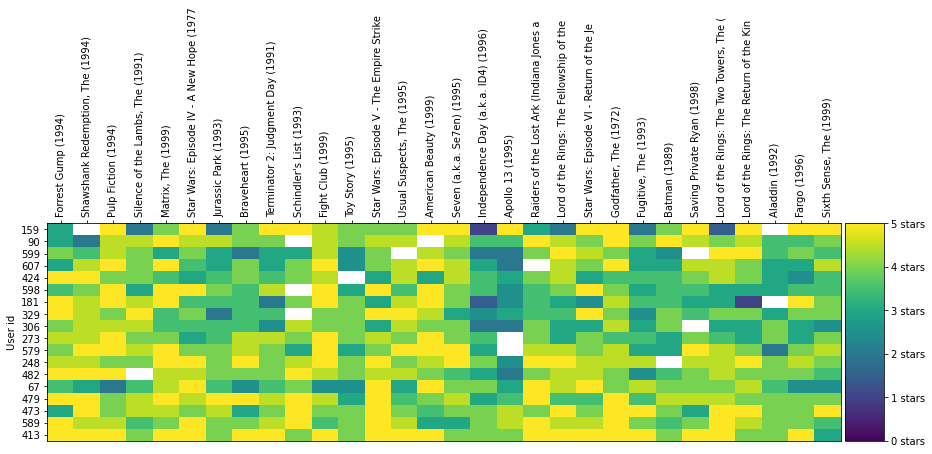

In [ ]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
plt.show()
# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [ ]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [ ]:
most_rated_movies_1k.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996),...,Gandhi (1982),Cube (1997),Forever Young (1992),Spy Game (2001),Pride & Prejudice (2005),Patch Adams (1998),Rise of the Planet of the Apes (2011),Bedazzled (2000),"Princess Diaries, The (2001)",Avengers: Age of Ultron (2015),All the President's Men (1976),Wallace & Gromit: The Best of Aardman Animation (1996),Scent of a Woman (1992),Star Trek Into Darkness (2013),Ghost in the Shell (Kôkaku kidôtai) (1995),Do the Right Thing (1989),Spawn (1997),Birdman: Or (The Unexpected Virtue of Ignorance) (2014),Arrival (2016),Airheads (1994),"13th Warrior, The (1999)",Private Parts (1997),"Lost Boys, The (1987)","Naked Gun 2 1/2: The Smell of Fear, The (1991)",The Hunger Games: Catching Fire (2013),"Mighty Ducks, The (1992)","Village, The (2004)",Buffy the Vampire Slayer (1992),In & Out (1997),Bad Santa (2003),Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,5.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(most_rated_movies_1k.fillna(-1))

In [ ]:
# use SVD to reduce the dimensionality
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=1)
sparse_ratings = svd.fit_transform(sparse_ratings)

In [ ]:
# 20 clusters / take 32
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the max number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
#draw_movie_clusters(clustered, max_users, max_movies)
clustered.head(10)

,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Cube (1997),Forever Young (1992),Spy Game (2001),Pride & Prejudice (2005),Patch Adams (1998),Rise of the Planet of the Apes (2011),Bedazzled (2000),"Princess Diaries, The (2001)",Avengers: Age of Ultron (2015),All the President's Men (1976),Wallace & Gromit: The Best of Aardman Animation (1996),Scent of a Woman (1992),Star Trek Into Darkness (2013),Ghost in the Shell (Kôkaku kidôtai) (1995),Do the Right Thing (1989),Spawn (1997),Birdman: Or (The Unexpected Virtue of Ignorance) (2014),Arrival (2016),Airheads (1994),"13th Warrior, The (1999)",Private Parts (1997),"Lost Boys, The (1987)","Naked Gun 2 1/2: The Smell of Fear, The (1991)",The Hunger Games: Catching Fire (2013),"Mighty Ducks, The (1992)","Village, The (2004)",Buffy the Vampire Slayer (1992),In & Out (1997),Bad Santa (2003),Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990),group
0,0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,6
1,1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3,3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,5.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,16
4,4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
5,5,5.0,5.0,2.0,4.0,NaN,NaN,5.0,5.0,3.0,3.0,NaN,NaN,NaN,1.0,NaN,4.0,5.0,4.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,5.0,3.0,NaN,4.0,4.0,5.0,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
clustered[clustered.group == 16].head(20)
# then take 10 top rated movies from users in same cluster that do not interacts with movies watched by chosen user

,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Cube (1997),Forever Young (1992),Spy Game (2001),Pride & Prejudice (2005),Patch Adams (1998),Rise of the Planet of the Apes (2011),Bedazzled (2000),"Princess Diaries, The (2001)",Avengers: Age of Ultron (2015),All the President's Men (1976),Wallace & Gromit: The Best of Aardman Animation (1996),Scent of a Woman (1992),Star Trek Into Darkness (2013),Ghost in the Shell (Kôkaku kidôtai) (1995),Do the Right Thing (1989),Spawn (1997),Birdman: Or (The Unexpected Virtue of Ignorance) (2014),Arrival (2016),Airheads (1994),"13th Warrior, The (1999)",Private Parts (1997),"Lost Boys, The (1987)","Naked Gun 2 1/2: The Smell of Fear, The (1991)",The Hunger Games: Catching Fire (2013),"Mighty Ducks, The (1992)","Village, The (2004)",Buffy the Vampire Slayer (1992),In & Out (1997),Bad Santa (2003),Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990),group
3,3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,5.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,16
83,83,5.0,5.0,4.0,5.0,NaN,4.0,3.0,NaN,NaN,5.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,5.0,4.0,NaN,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0,NaN,3.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
136,136,3.5,3.5,3.0,4.0,4.0,4.0,3.5,4.0,3.5,3.5,3.0,4.0,4.0,NaN,NaN,NaN,3.0,3.5,4.5,5.0,3.0,5.0,NaN,NaN,4.0,4.5,5.0,4.0,4.5,4.5,NaN,NaN,NaN,3.5,NaN,4.0,3.5,3.5,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
155,155,3.0,4.5,5.0,4.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,4.5,3.5,NaN,4.0,4.0,NaN,NaN,5.0,3.5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,3.5,3.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,3.5,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,16
198,198,2.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,3.5,5.0,NaN,NaN,3.5,4.0,5.0,3.0,3.0,4.0,4.0,NaN,2.0,4.0,4.0,3.0,4.0,NaN,NaN,NaN,5.0,4.0,3.0,NaN,NaN,NaN,2.0,NaN,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,16
220,220,3.5,4.0,5.0,4.0,2.0,NaN,3.0,NaN,4.5,3.0,5.0,NaN,NaN,4.5,5.0,NaN,2.0,NaN,3.5,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.5,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,...,Na

In [ ]:
user = 3
max_rate = clustered[clustered.group == 16].iloc[:, 1:-1].mean(axis=0)

In [ ]:
user_row = clustered[clustered.index==3].iloc[:, 1:-1]

In [ ]:
user_row.fillna(-1, inplace=True)

In [ ]:
data = pd.DataFrame()
for u, m, col in zip(user_row.iloc[0,:], max_rate, clustered.columns[1:-1]):
    if u == -1:
        data = data.append({'title': col, 'rating': m}, ignore_index=True)
data = data.sort_values(by='rating', ascending=False)
data.head(10)

,rating,title
626,5.000000,"Femme Nikita, La (Nikita) (1990)"
477,5.000000,Fast Times at Ridgemont High (1982)
783,5.000000,Sleepers (1996)
426,5.000000,Bill & Ted's Excellent Adventure (1989)
308,5.000000,Wallace & Gromit: The Wrong Trousers (1993)
504,5.000000,Into the Wild (2007)
319,5.000000,Zoolander (2001)
416,5.000000,"Pianist, The (2002)"
161,4.857143,"Graduate, The (1967)"
283,4.833333,Bowling for Columbine (2002)


In [ ]:
# actually we took user-item sparse matrix, reduced its dim and found cluster (also use elbow, sihluets for k)
# for similar users, then took 10 best rated movies from this cluster, that selected user did not watch (rate)